In [1]:
%%capture
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import numpy as np
import utils

In [2]:
import tensorflow as tf
from keras import layers, Model
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.__version__)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=6000)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

Num GPUs Available:  1
2.15.0
1 Physical GPUs, 1 Logical GPUs


In [3]:
#set the necessary seeds
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

## Import datasets

### Breast cancer dataset

In [4]:
train_pairs_breast, val_pairs_breast, test_pairs_breast = utils.split_dataset(utils.create_list())
print(f"Number of training pairs: {len(train_pairs_breast)}")
print(f"Number of val pairs: {len(val_pairs_breast)}")
print(f"Number of test_pairs pairs: {len(test_pairs_breast)}")

Number of training pairs: 388
Number of val pairs: 129
Number of test_pairs pairs: 130


In [5]:
train_dataset_breast = utils.create_dataset(train_pairs_breast, augment=True)
val_dataset_breast = utils.create_dataset(val_pairs_breast)
test_dataset_breast = utils.create_dataset(test_pairs_breast)

In [6]:
batch_size = 8

In [7]:
#batch the dataset and shuffle the training set

train_dataset_breast = train_dataset_breast.shuffle(buffer_size=len(train_pairs_breast)).batch(batch_size)
val_dataset_breast = val_dataset_breast.batch(batch_size)
test_dataset_breast = test_dataset_breast.batch(batch_size)

### Skin cancer dataset

In [ ]:
### Skin cancer dataset
train_dataset_skin = utils.create_dataset(utils.create_list_skin("ISIC-2017_Training_Data", "ISIC-2017_Training_Part1_GroundTruth"), augment=True)
val_dataset_skin = utils.create_dataset(utils.create_list_skin("ISIC-2017_Validation_Data", "ISIC-2017_Validation_Part1_GroundTruth"))
test_dataset_skin = utils.create_dataset(utils.create_list_skin("ISIC-2017_Test_v2_Data", "ISIC-2017_Test_v2_Part1_GroundTruth"))

In [ ]:
train_dataset_skin = train_dataset_skin.shuffle(buffer_size=2000).batch(batch_size)
val_dataset_skin = val_dataset_skin.batch(batch_size)
test_dataset_skin = test_dataset_skin.batch(batch_size)

### Brain cancer dataset

In [ ]:
train_pairs_brain, val_pairs_brain, test_pairs_brain = utils.split_dataset(utils.create_list_brain())
print(f"Number of training pairs: {len(train_pairs_brain)}")
print(f"Number of val pairs: {len(val_pairs_brain)}")
print(f"Number of test_pairs pairs: {len(test_pairs_brain)}")

In [ ]:
train_dataset_brain = utils.create_dataset(train_pairs_brain, augment=True)
val_dataset_brain = utils.create_dataset(val_pairs_brain)
test_dataset_brain = utils.create_dataset(test_pairs_brain)

In [ ]:
train_dataset_brain = train_dataset_brain.shuffle(buffer_size=len(train_pairs_brain)).batch(batch_size)
val_dataset_brain = val_dataset_brain.batch(batch_size)
test_dataset_brain = test_dataset_brain.batch(batch_size)

## Architecture definition

In [14]:
#convolutional layer
def convolutional_layer(input, num_filters, kernel_size=(3, 3), initializer="he_normal"):

    #first convolution
    x = layers.Conv2D(filters=num_filters, kernel_size = kernel_size, padding='same', kernel_initializer=initializer)(input)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    #second convolution
    x = layers.Conv2D(filters=num_filters, kernel_size=kernel_size, padding='same', kernel_initializer=initializer)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    return x

In [15]:
#attention gate
def attention_gate(x, g, shape):
    #match dimensions of g and x
    g = layers.Conv2D(filters=shape, kernel_size=(1, 1), strides=1, padding='same')(g)
    g = layers.BatchNormalization()(g)
    x = layers.Conv2D(filters=shape, kernel_size=(1, 1), strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)

    #sum the features
    addition = layers.Add()([g, x])
    addition = layers.Activation('relu')(addition)

    #collapse the dimensions
    attention_map = layers.Conv2D(filters=1, kernel_size=(1, 1), strides=1, padding='same')(addition)
    attention_map = layers.Activation('sigmoid')(attention_map)

    # #upsample to match the original size
    # upsampled = layers.UpSampling2D((2, 2), interpolation="bilinear")(attention_map)

    #final multiplication
    output = layers.Multiply()([x, attention_map])

    return output

In [16]:
def attention_unet(input_shape, num_filters=16):
    inputs = layers.Input(input_shape)

    #encoder block
    first_conv = convolutional_layer(inputs, num_filters)
    first_layer = layers.MaxPool2D(pool_size=(2, 2))(first_conv)
    first_layer = layers.Dropout(0.1)(first_layer)

    second_conv = convolutional_layer(first_layer, num_filters * 2)
    second_layer = layers.MaxPool2D(pool_size=(2, 2))(second_conv)
    second_layer = layers.Dropout(0.1)(second_layer)

    third_conv = convolutional_layer(second_layer, num_filters * 4)
    third_layer = layers.MaxPool2D(pool_size=(2, 2))(third_conv)
    third_layer = layers.Dropout(0.1)(third_layer)

    fourth_conv = convolutional_layer(third_layer, num_filters * 8)
    fourth_layer = layers.MaxPool2D(pool_size=(2, 2))(fourth_conv)
    fourth_layer = layers.Dropout(0.1)(fourth_layer)

    fifth_conv = convolutional_layer(fourth_layer, num_filters * 16)

    #decoder block with attention
    first_deconv = layers.Conv2DTranspose(num_filters * 8, kernel_size=(3, 3), strides=(2, 2), padding='same')(fifth_conv)
    first_att = attention_gate(fourth_conv, first_deconv, num_filters * 8)
    sixth_layer = layers.concatenate([first_deconv, first_att])
    sixth_layer = layers.Dropout(0.2)(sixth_layer)
    sixth_conv = convolutional_layer(sixth_layer, num_filters * 8)

    second_deconv = layers.Conv2DTranspose(num_filters * 4, kernel_size=(3, 3), strides=(2, 2), padding='same')(sixth_conv)
    second_att = attention_gate(third_conv, second_deconv, num_filters * 4)
    seventh_layer = layers.concatenate([second_deconv, second_att])
    seventh_layer = layers.Dropout(0.2)(seventh_layer)
    seventh_conv = convolutional_layer(seventh_layer, num_filters * 4)

    third_deconv = layers.Conv2DTranspose(num_filters * 2, kernel_size=(3, 3), strides=(2, 2), padding='same')(seventh_conv)
    third_att = attention_gate(second_conv, third_deconv, num_filters * 2)
    eighth_layer = layers.concatenate([third_deconv, third_att])
    eighth_layer = layers.Dropout(0.2)(eighth_layer)
    eighth_conv = convolutional_layer(eighth_layer, num_filters * 2)

    fourth_deconv = layers.Conv2DTranspose(num_filters, kernel_size=(3, 3), strides=(2, 2), padding='same')(eighth_conv)
    fourth_att = attention_gate(first_conv, fourth_deconv, num_filters)
    ninth_layer = layers.concatenate([fourth_deconv, fourth_att])
    ninth_layer = layers.Dropout(0.2)(ninth_layer)
    ninth_conv = convolutional_layer(ninth_layer, num_filters)

    #output layer
    output = layers.Conv2D(1, kernel_size=(1, 1), activation="sigmoid")(ninth_conv)

    attention_unet = Model(inputs=inputs, outputs=output)

    return attention_unet

In [11]:
tf.keras.utils.get_custom_objects()["dice_loss"] = utils.dice_loss
tf.keras.utils.get_custom_objects()["bce_dice_loss"] = utils.bce_dice_loss
tf.keras.utils.get_custom_objects()["tversky_loss"] = utils.tversky_loss
tf.keras.utils.get_custom_objects()["dice_coefficient"] = utils.dice_coefficient
tf.keras.utils.get_custom_objects()["iou"] = utils.iou

In [17]:
attention_unet = attention_unet(input_shape=(256, 256, 3))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
lr_adapter = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_dice_coefficient", mode = "max", factor=0.1, patience=7, min_lr=0.000001)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_dice_coefficient", mode= "max", patience=13, restore_best_weights=True)

attention_unet.compile(optimizer=optimizer, loss=utils.tversky_loss, metrics=[utils.dice_coefficient, utils.iou, "accuracy"])

In [27]:
attention_unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_59 (Conv2D)          (None, 256, 256, 16)         448       ['input_6[0][0]']             
                                                                                                  
 batch_normalization_50 (Ba  (None, 256, 256, 16)         64        ['conv2d_59[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_52 (Activation)  (None, 256, 256, 16)         0         ['batch_normalization_50[0

### Fit on the breast cancer dataset

In [28]:
#non cambiare!!

best_history_breast = attention_unet.fit(train_dataset_breast, validation_data=val_dataset_breast, epochs=100, callbacks=[lr_adapter, early_stopping])

Epoch 1/100


I0000 00:00:1738928898.491832      81 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


49/49 [==============================] - 46s 349ms/step - loss: 0.6390 - dice_coefficient: 0.2793 - iou: 0.1648 - accuracy: 0.6216 - val_loss: 0.7545 - val_dice_coefficient: 0.1620 - val_iou: 0.0897 - val_accuracy: 0.3321 - lr: 0.0010
Epoch 2/100
49/49 [==============================] - 7s 111ms/step - loss: 0.5679 - dice_coefficient: 0.3416 - iou: 0.2096 - accuracy: 0.6907 - val_loss: 0.7502 - val_dice_coefficient: 0.1604 - val_iou: 0.0887 - val_accuracy: 0.1788 - lr: 0.0010
Epoch 3/100
49/49 [==============================] - 7s 112ms/step - loss: 0.5234 - dice_coefficient: 0.3871 - iou: 0.2450 - accuracy: 0.7485 - val_loss: 0.6537 - val_dice_coefficient: 0.2372 - val_iou: 0.1380 - val_accuracy: 0.5827 - lr: 0.0010
Epoch 4/100
49/49 [==============================] - 7s 111ms/step - loss: 0.5021 - dice_coefficient: 0.4200 - iou: 0.2717 - accuracy: 0.7905 - val_loss: 0.6855 - val_dice_coefficient: 0.2093 - val_iou: 0.1196 - val_accuracy: 0.4428 - lr: 0.0010
Epoch 5/100
49/49 [========

In [18]:
history_breast = attention_unet.fit(train_dataset_breast, validation_data=val_dataset_breast, epochs=100, callbacks=[lr_adapter, early_stopping])

Epoch 1/100
49/49 [==============================] - 26s 183ms/step - loss: 0.6449 - dice_coefficient: 0.2650 - iou: 0.1556 - accuracy: 0.4890 - val_loss: 0.7675 - val_dice_coefficient: 0.1481 - val_iou: 0.0813 - val_accuracy: 0.0845 - lr: 0.0010
Epoch 2/100
49/49 [==============================] - 9s 168ms/step - loss: 0.6026 - dice_coefficient: 0.3067 - iou: 0.1854 - accuracy: 0.6556 - val_loss: 0.7649 - val_dice_coefficient: 0.1500 - val_iou: 0.0824 - val_accuracy: 0.0990 - lr: 0.0010
Epoch 3/100
49/49 [==============================] - 10s 170ms/step - loss: 0.5609 - dice_coefficient: 0.3425 - iou: 0.2095 - accuracy: 0.7156 - val_loss: 0.7531 - val_dice_coefficient: 0.1584 - val_iou: 0.0875 - val_accuracy: 0.1663 - lr: 0.0010
Epoch 4/100
49/49 [==============================] - 10s 174ms/step - loss: 0.5402 - dice_coefficient: 0.3693 - iou: 0.2302 - accuracy: 0.7517 - val_loss: 0.7614 - val_dice_coefficient: 0.1525 - val_iou: 0.0839 - val_accuracy: 0.1167 - lr: 0.0010
Epoch 5/100
4

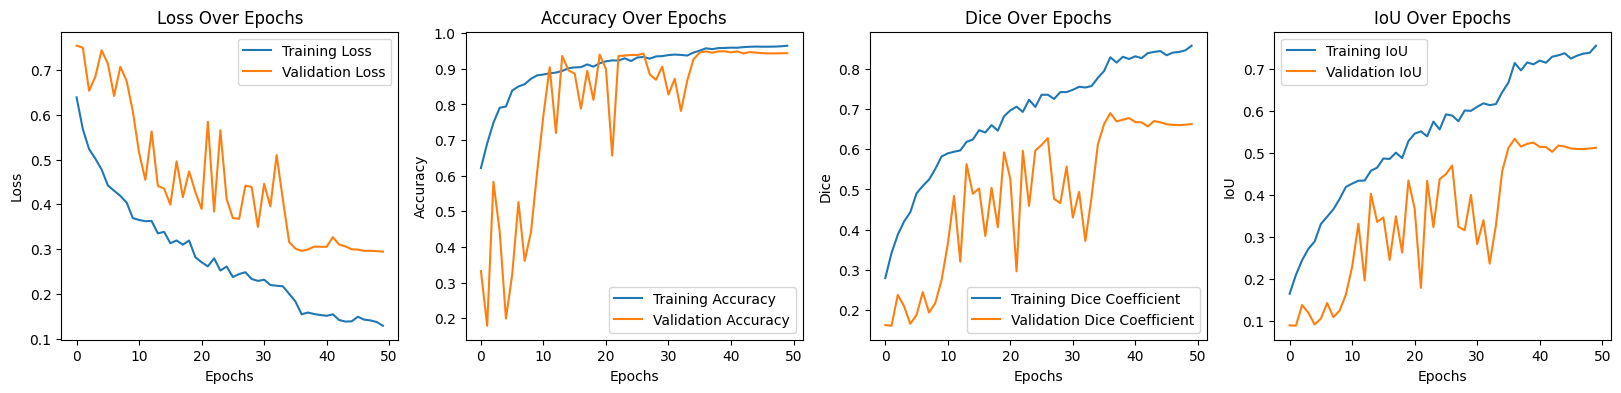

In [29]:
history_dict = history_breast.history

#plot Loss
plt.figure(figsize=(20, 4))

plt.subplot(1, 4, 1)
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()

#plot accuracy
if 'accuracy' in history_dict:
    plt.subplot(1, 4, 2)
    plt.plot(history_dict['accuracy'], label='Training Accuracy')
    plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.legend()

#plot dice
if 'dice_coefficient' in history_dict:
    plt.subplot(1, 4, 3)
    plt.plot(history_dict['dice_coefficient'], label='Training Dice Coefficient')
    plt.plot(history_dict['val_dice_coefficient'], label='Validation Dice Coefficient')
    plt.xlabel('Epochs')
    plt.ylabel('Dice')
    plt.title('Dice Over Epochs')
    plt.legend()

#plot iou
if 'iou' in history_dict:
    plt.subplot(1, 4, 4)
    plt.plot(history_dict['iou'], label='Training IoU')
    plt.plot(history_dict['val_iou'], label='Validation IoU')
    plt.xlabel('Epochs')
    plt.ylabel('IoU')
    plt.title('IoU Over Epochs')
    plt.legend()

plt.show()

In [37]:
attention_unet.save("attention_unet_best_breast.h5")

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [22]:
test_loss, test_dice, test_iou, test_accuracy = attention_unet.evaluate(test_dataset_breast)

17/17 [==============================] - 1s 35ms/step - loss: 0.4670 - dice_coefficient: 0.5583 - iou: 0.4009 - accuracy: 0.9345


1/1 [==============================] - 0s 26ms/step


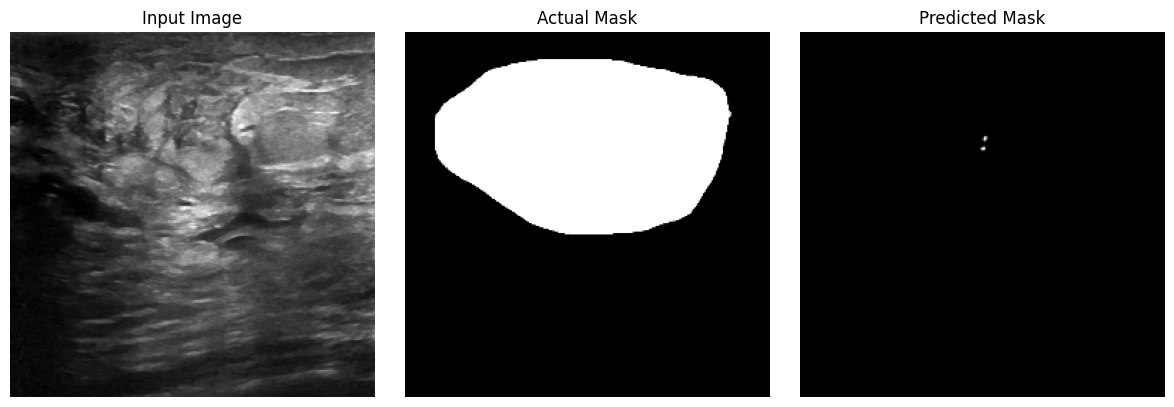

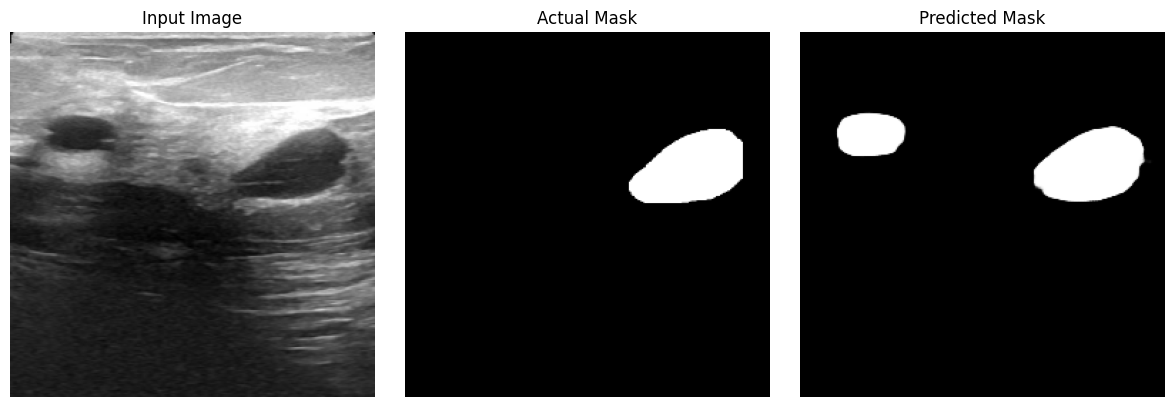

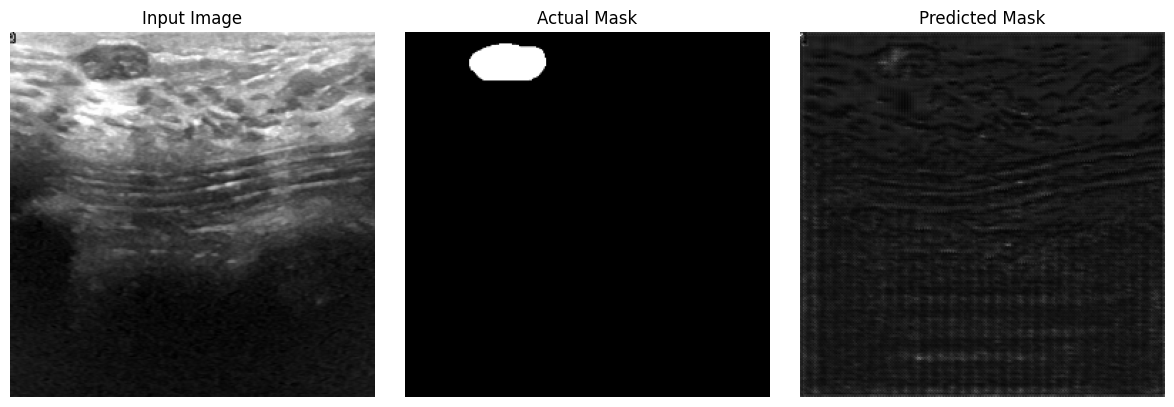

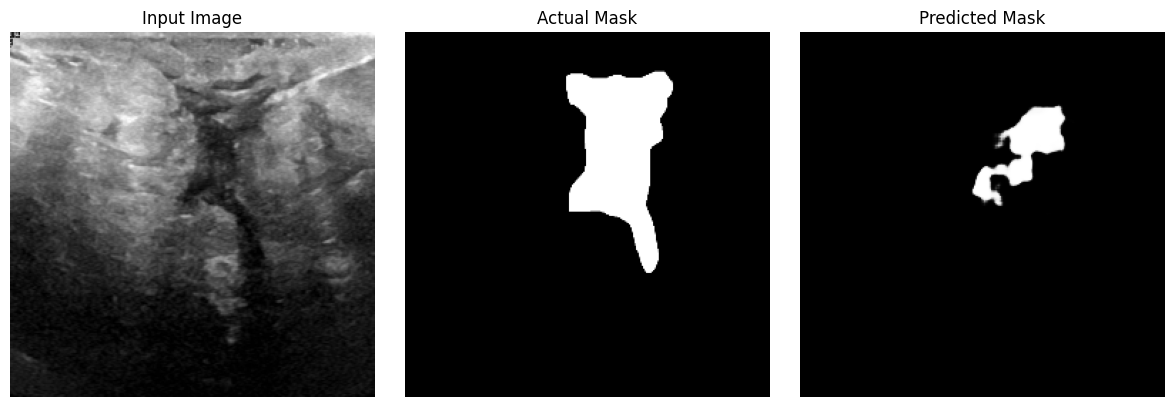

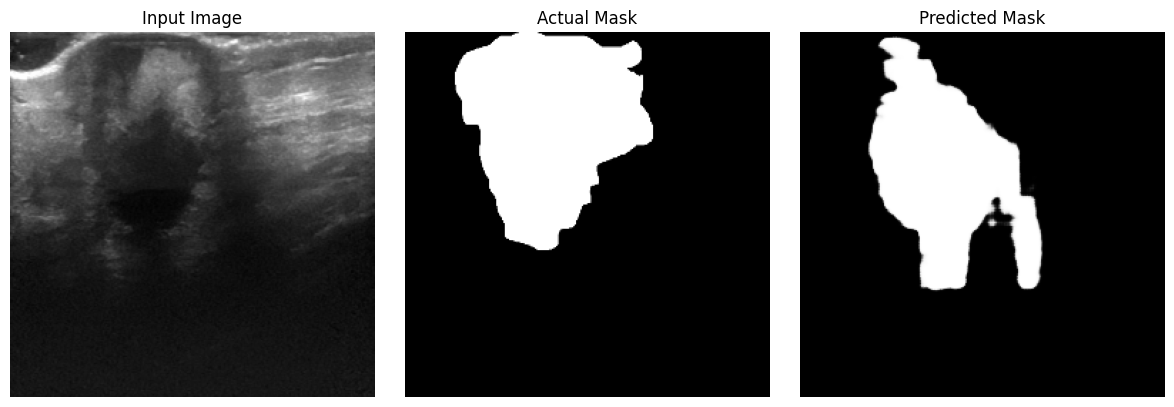

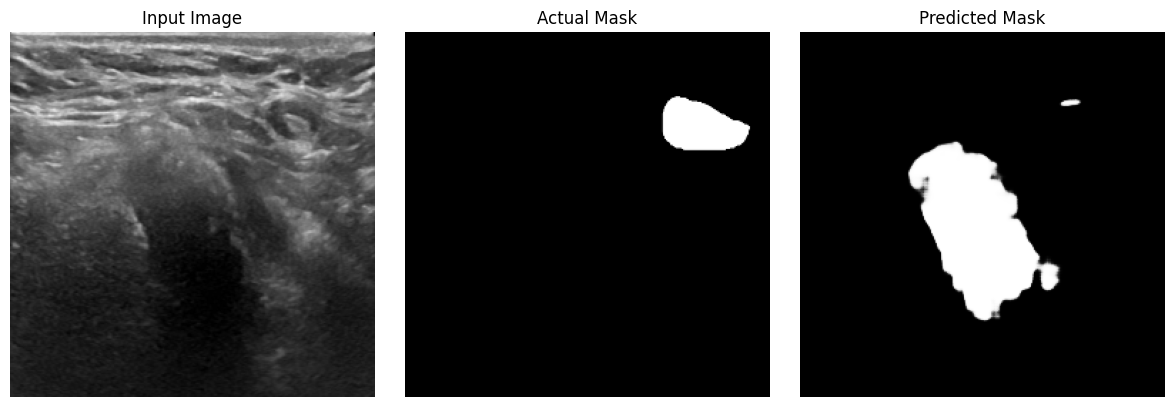

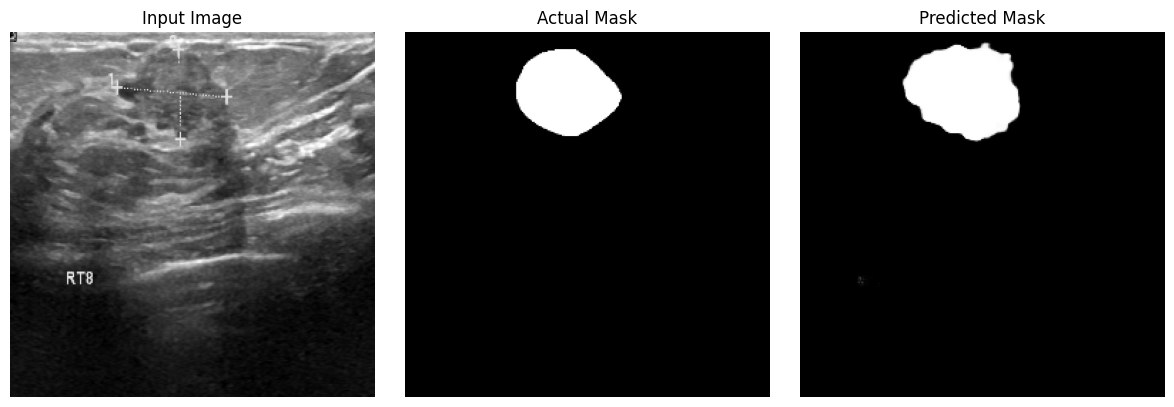

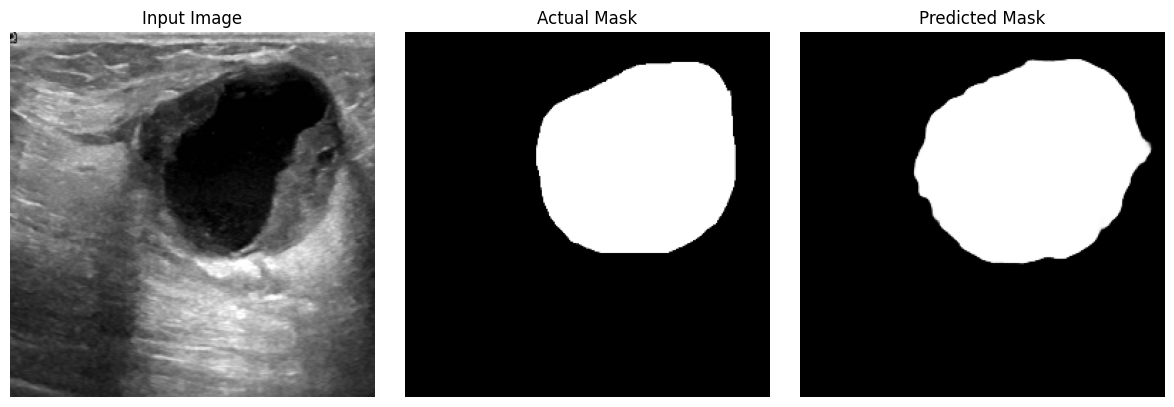

In [36]:
for i, (image, mask) in enumerate(test_dataset_breast.take(1)):
    predicted_mask = attention_unet.predict(image)

    for j in range(image.shape[0]):
        plt.figure(figsize=(12, 4))

        #display the input image
        plt.subplot(1, 3, 1)
        plt.imshow(image[j])
        plt.title("Input Image")
        plt.axis('off')

        # Display the actual mask
        plt.subplot(1, 3, 2)
        plt.imshow(mask[j], cmap='gray')
        plt.title("Actual Mask")
        plt.axis('off')

        # Display the predicted mask
        plt.subplot(1, 3, 3)
        plt.imshow(predicted_mask[j], cmap='gray')  #
        plt.title("Predicted Mask")
        plt.axis('off')

        plt.tight_layout()
        plt.show()